In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (602).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (289).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (216).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (616).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (684).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (154).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (608).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (642).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (171).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (341).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (652).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (177).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (768).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (598).jpg
/kaggle/input/tomatofruits/Three Classes/Unripe/unripe (708).jpg
/kaggle/input/tomatofruit

In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

2024-06-09 12:03:14.969781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 12:03:14.969878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 12:03:15.104623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [1]:
import numpy as np
import pandas as pd
import os

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, vgg19, VGG19_Weights
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from copy import deepcopy

In [2]:
train_data_path = '/kaggle/input/tomatofruits/Three Classes'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)
test_data_path = '/kaggle/input/tomatofruits/Three Classes'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [2]:
def create_df(base_dir, mp):
    x = []
    y = []
    for i in os.listdir(base_dir):
        label_path = os.path.join(base_dir, i)
        for j in os.listdir(label_path):
            im_path = os.path.join(label_path, j)
            original = Image.open(im_path).convert("RGB")
            x += [np.array(original)]
            y += [mp[i]]
            if i == "Reject":
                flipper = original.transpose(method=Image.FLIP_LEFT_RIGHT)
                x += [np.array(flipper)]
                y += [mp[i]]
    return x, y

In [3]:
EPOCHS = 30
IM_SIZE = 224
LR = 0.1
GAMMA = 0.1
STEP = 10
BATCH = 32
NUM_CLASSES = 3
base_dir = "/kaggle/input/tomatofruits/Three Classes"
class_index = {"Ripe": 0, "Unripe": 1, "Reject": 2}
index_class = {0: "Ripe", 1: "Unripe", 2: "Reject"}

In [4]:
x, y = create_df(base_dir, class_index)
x_train, x_testing, y_train, y_testing = train_test_split(x, y, random_state=42, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_testing, y_testing, random_state=42, test_size=0.5)

In [3]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [4]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2400 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.


In [5]:
class Clod(Dataset):
    def __init__(self, data, target, transform):
        super(Clod, self).__init__()
        self.data = data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        image, label = self.data[x], self.target[x]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

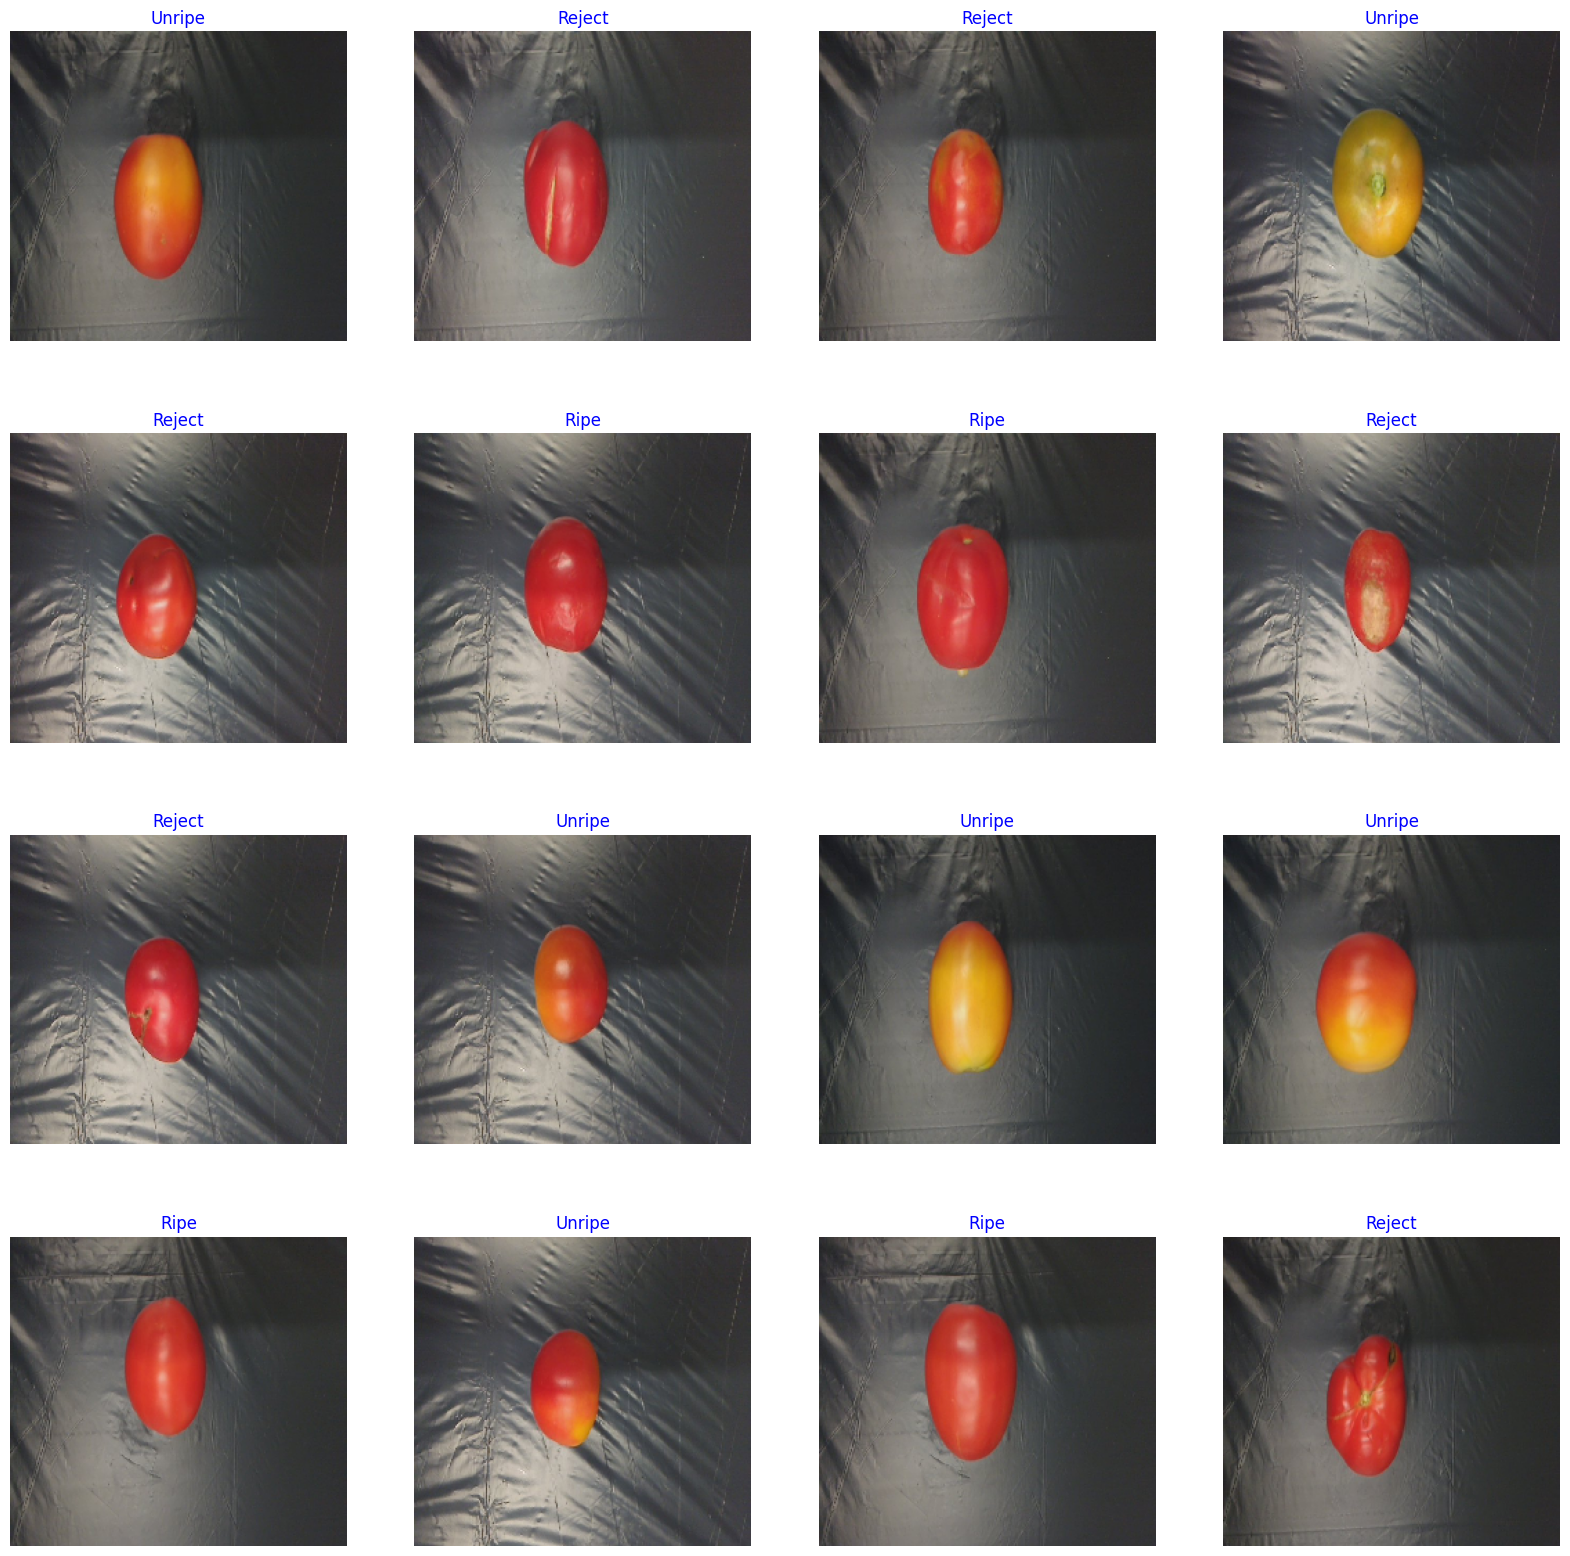

In [5]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [6]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.ToTensor(),
                                transforms.Resize((IM_SIZE, IM_SIZE)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])


In [7]:
train_ds = Clod(x_train, y_train, transform)
val_ds = Clod(x_val, y_val, transform)

In [8]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [9]:
# Training function
def train_model(model, optimizer, scheduler):
    best_model = deepcopy(model)
    best_acc = 0

    acc_train = []
    acc_val = []
    loss_train = []
    loss_val = []

    for epoch in range(1, EPOCHS + 1):
        model.train()

        train_loss = 0
        train_acc = 0
        train_total = 0

        for data, label in train_dl:
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data, label = data.cuda(), label.cuda()

            out = model(data)
            loss = criterion(out, label)
            train_loss += loss.item()
            train_total += out.size(0)
            train_acc += (out.argmax(1) == label).sum().item()
            loss.backward()
            optimizer.step()

        train_loss /= train_total
        train_acc /= train_total

        model.eval()
        val_loss = 0
        val_total = 0
        val_acc = 0

        with torch.no_grad():
            for data, label in val_dl:
                if torch.cuda.is_available():
                    data, label = data.cuda(), label.cuda()

                out = model(data)
                loss = criterion(out, label)
                val_loss += loss.item()
                val_acc += (out.argmax(1) == label).sum().item()
                val_total += out.size(0)

        val_loss /= val_total
        val_acc /= val_total

        acc_train.append(train_acc)
        acc_val.append(val_acc)
        loss_train.append(train_loss)
        loss_val.append(val_loss)

        if val_acc > best_acc:
            best_model = deepcopy(model)
            best_acc = val_acc

        print(f"Epoch {epoch} train loss {train_loss:.4f} train acc {train_acc:.4f} val loss {val_loss:.4f} val acc {val_acc:.4f}")

        scheduler.step()

    return best_model, acc_train, acc_val, loss_train, loss_val

In [44]:
import torch.nn as nn
import torch.optim as optim

model_vgg19 = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
for param in model_vgg19.parameters():
    param.requires_grad = False
num_ftrs = model_vgg19.classifier[0].in_features
model_vgg19.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 2048),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(512, NUM_CLASSES)
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vgg19 = model_vgg19.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer_vgg19 = torch.optim.SGD(model_vgg19.classifier.parameters(), lr=LR, momentum=0.9)
scheduler_vgg19 = torch.optim.lr_scheduler.StepLR(optimizer_vgg19, step_size=STEP, gamma=GAMMA)

best_model_vgg19, acc_train_vgg19, acc_val_vgg19, loss_train_vgg19, loss_val_vgg19 = train_model(model_vgg19, optimizer_vgg19, scheduler_vgg19)

Epoch 1 train loss 0.0280 train acc 0.5449 val loss 0.0183 val acc 0.7906
Epoch 2 train loss 0.0174 train acc 0.7543 val loss 0.0101 val acc 0.8688
Epoch 3 train loss 0.0114 train acc 0.8473 val loss 0.0125 val acc 0.7969
Epoch 4 train loss 0.0097 train acc 0.8742 val loss 0.0094 val acc 0.8531
Epoch 5 train loss 0.0096 train acc 0.8820 val loss 0.0074 val acc 0.9219
Epoch 6 train loss 0.0089 train acc 0.8867 val loss 0.0078 val acc 0.8938
Epoch 7 train loss 0.0090 train acc 0.8875 val loss 0.0073 val acc 0.8938
Epoch 8 train loss 0.0082 train acc 0.8883 val loss 0.0080 val acc 0.9000
Epoch 9 train loss 0.0080 train acc 0.8984 val loss 0.0061 val acc 0.9375
Epoch 10 train loss 0.0079 train acc 0.9012 val loss 0.0065 val acc 0.9281
Epoch 11 train loss 0.0067 train acc 0.9086 val loss 0.0055 val acc 0.9406
Epoch 12 train loss 0.0060 train acc 0.9262 val loss 0.0053 val acc 0.9406
Epoch 13 train loss 0.0056 train acc 0.9246 val loss 0.0054 val acc 0.9437
Epoch 14 train loss 0.0057 train a

In [24]:
import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# Use EfficientNetB4
model_efficientnet = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
num_ftrs = model_efficientnet.classifier[1].in_features
model_efficientnet.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_efficientnet = model_efficientnet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_efficientnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# best_model_efficientnet, acc_train_efficie/ntnet, acc_val_efficientnet, loss_train_efficientnet, loss_val_efficientnet = train_model(model_efficientnet, optimizer, scheduler)
best_model_efficientnet, acc_train_efficientnet, acc_val_efficientnet, loss_train_efficientnet, loss_val_efficientnet = train_model(model_efficientnet, optimizer, scheduler)

Epoch 1 train loss 0.0126 train acc 0.8340 val loss 0.0066 val acc 0.9156
Epoch 2 train loss 0.0064 train acc 0.9242 val loss 0.0058 val acc 0.9406
Epoch 3 train loss 0.0050 train acc 0.9437 val loss 0.0053 val acc 0.9406
Epoch 4 train loss 0.0032 train acc 0.9617 val loss 0.0050 val acc 0.9375
Epoch 5 train loss 0.0022 train acc 0.9719 val loss 0.0049 val acc 0.9469
Epoch 6 train loss 0.0013 train acc 0.9836 val loss 0.0056 val acc 0.9406
Epoch 7 train loss 0.0010 train acc 0.9891 val loss 0.0056 val acc 0.9406
Epoch 8 train loss 0.0015 train acc 0.9867 val loss 0.0051 val acc 0.9469
Epoch 9 train loss 0.0008 train acc 0.9895 val loss 0.0076 val acc 0.9500
Epoch 10 train loss 0.0006 train acc 0.9918 val loss 0.0079 val acc 0.9406
Epoch 11 train loss 0.0010 train acc 0.9902 val loss 0.0052 val acc 0.9563
Epoch 12 train loss 0.0003 train acc 0.9969 val loss 0.0054 val acc 0.9531
Epoch 13 train loss 0.0002 train acc 0.9980 val loss 0.0062 val acc 0.9531
Epoch 14 train loss 0.0002 train a

In [28]:
# Define a new model with the same architecture
model_vgg19_new = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
num_ftrs = model_vgg19_new.classifier[0].in_features
model_vgg19_new.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 2048),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(512, NUM_CLASSES)
)

model_vgg19_new = model_vgg19_new.to(device)
optimizer_vgg19_new = torch.optim.SGD(model_vgg19_new.parameters(), lr=LR, momentum=0.9)
scheduler_vgg19_new = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_vgg19_new, mode='min', factor=0.1, patience=5)

best_model_vgg19_new, acc_train_vgg19_new, acc_val_vgg19_new, loss_train_vgg19_new, loss_val_vgg19_new = train_model(model_vgg19_new, optimizer_vgg19_new, scheduler_vgg19_new)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 161MB/s]  


Epoch 1 train loss 0.0254 train acc 0.5676 val loss 0.0182 val acc 0.7469
Epoch 2 train loss 0.0174 train acc 0.8090 val loss 0.0103 val acc 0.9219
Epoch 3 train loss 0.0130 train acc 0.8605 val loss 0.0074 val acc 0.9250
Epoch 4 train loss 0.0105 train acc 0.8938 val loss 0.0114 val acc 0.9094
Epoch 5 train loss 0.0107 train acc 0.8836 val loss 0.0073 val acc 0.9031
Epoch 6 train loss 0.0072 train acc 0.9230 val loss 0.0056 val acc 0.9531
Epoch 7 train loss 0.0065 train acc 0.9332 val loss 0.0043 val acc 0.9531
Epoch 8 train loss 0.0064 train acc 0.9207 val loss 0.0041 val acc 0.9344
Epoch 9 train loss 0.0054 train acc 0.9461 val loss 0.0085 val acc 0.9156
Epoch 10 train loss 0.0045 train acc 0.9523 val loss 0.0064 val acc 0.9156
Epoch 11 train loss 0.0041 train acc 0.9586 val loss 0.0056 val acc 0.9281
Epoch 12 train loss 0.0035 train acc 0.9645 val loss 0.0042 val acc 0.9563
Epoch 13 train loss 0.0052 train acc 0.9449 val loss 0.0035 val acc 0.9563
Epoch 14 train loss 0.0029 train a

In [10]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Use ResNet50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
best_model_efficientnet, acc_train_efficientnet, acc_val_efficientnet, loss_train_efficientnet, loss_val_efficientnet = train_model(model, optimizer, scheduler)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 train loss 0.0117 train acc 0.8492 val loss 0.0073 val acc 0.9344
Epoch 2 train loss 0.0065 train acc 0.9242 val loss 0.0102 val acc 0.8750
Epoch 3 train loss 0.0051 train acc 0.9406 val loss 0.0065 val acc 0.9062
Epoch 4 train loss 0.0033 train acc 0.9551 val loss 0.0099 val acc 0.9000
Epoch 5 train loss 0.0027 train acc 0.9707 val loss 0.0069 val acc 0.9094
Epoch 6 train loss 0.0020 train acc 0.9750 val loss 0.0100 val acc 0.8781
Epoch 7 train loss 0.0022 train acc 0.9766 val loss 0.0041 val acc 0.9563
Epoch 8 train loss 0.0010 train acc 0.9906 val loss 0.0045 val acc 0.9500
Epoch 9 train loss 0.0017 train acc 0.9816 val loss 0.0047 val acc 0.9563
Epoch 10 train loss 0.0009 train acc 0.9906 val loss 0.0048 val acc 0.9500
Epoch 11 train loss 0.0003 train acc 0.9980 val loss 0.0043 val acc 0.9531
Epoch 12 train loss 0.0002 train acc 0.9988 val loss 0.0043 val acc 0.9594
Epoch 13 train loss 0.0002 train acc 0.9988 val loss 0.0046 val acc 0.9500
Epoch 14 train loss 0.0001 train a

In [13]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l2= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [14]:
Epochs = 20

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/20


W0000 00:00:1717940128.957764     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5651 - loss: 12.3922

W0000 00:00:1717940205.766869     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/150 ━━━━━━━━━━━━━━━━━━━━ 529s 561ms/step - accuracy: 0.5652 - loss: 12.3722 - val_accuracy: 0.7150 - val_loss: 7.3835
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 452ms/step - accuracy: 0.5765 - loss: 7.1117 - val_accuracy: 0.4408 - val_loss: 6.3119
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.5693 - loss: 6.0860 - val_accuracy: 0.5483 - val_loss: 5.3747
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 455ms/step - accuracy: 0.5662 - loss: 5.1644 - val_accuracy: 0.6458 - val_loss: 4.5738
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.5852 - loss: 4.3527 - val_accuracy: 0.6667 - val_loss: 3.8051
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 456ms/step - accuracy: 0.6785 - loss: 3.6608 - val_accuracy: 0.7742 - val_loss: 3.2927
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 454ms/step - accuracy: 0.7291 - loss: 3.0594 - val_accuracy: 0.7975 - val_loss: 2.6356
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.7368 - loss: 2.5589 - v

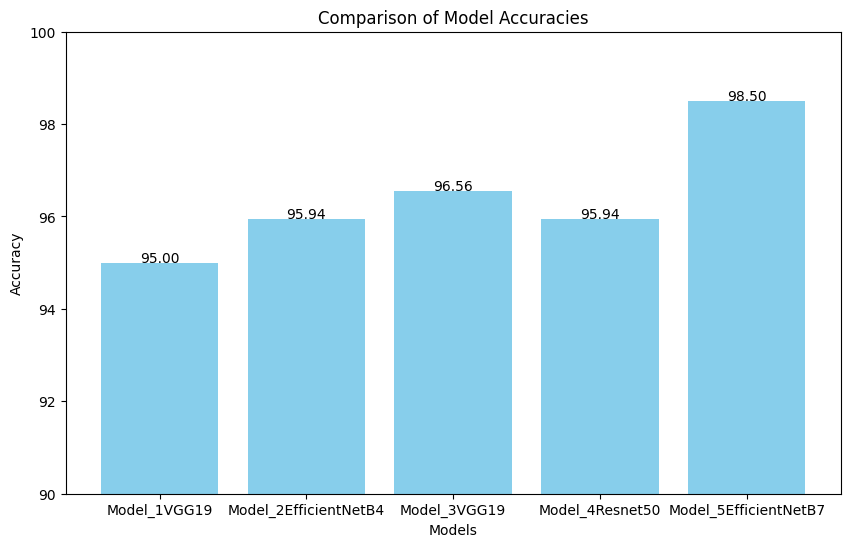

In [1]:
import matplotlib.pyplot as plt

# Replace these sample accuracies with your actual model accuracies
model_accuracies = [95, 95.94 , 96.56, 95.94, 98.5]
model_names = ['Model_1VGG19', 'Model_2EfficientNetB4', 'Model_3VGG19', 'Model_4Resnet50', 'Model_5EfficientNetB7']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color='skyblue')

# Adding the title and labels
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([90, 100])  # Adjust the range based on your accuracies

# Displaying the accuracy values on top of the bars
for i, accuracy in enumerate(model_accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center')

# Display the plot
plt.show()